## Этот код реализует обнаружение аномалий с использованием автоэнкодеров LSTM (Long Short-Term Memory) в TensorFlow. (Орындаған:Амангелд Н.Б.)

### **Загрузка библиотек**

In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed 
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(1)
tf.random.set_seed(1)
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.11.0


#### В этой задании рассматриваются:

* Обнаружение аномалий
* Автоэнкодеры LSTM
* Автоэнкодер LSTM в Tensorflow
* Поиск аномалий

**Что такое обнаружение аномалий?**

Обнаружение аномалий - это процесс выявления необычных событий или точек данных.
* Он имеет множество применений, таких как обнаружение мошеннических действий в банковской сфере, обнаружение опухолей при медицинской визуализации и выявление ошибок в письменном тексте

**Методы:**
* Множество контролируемых и неконтролируемых подходов. Некоторые из подходов включают в себя:
  * Одноклассовые SVM, байесовские сети, кластерный анализ и (конечно же) Нейронные сети.

**Автоэнкодеры**

Это метод обучения без контроля, который обучается с использованием методов контролируемого обучения. Во время обучения автоэнкодер корректирует свои значения и смещения, чтобы минимизировать ошибку восстановления, используя такие методы, как обратное распространение и градиентный спуск. Сводя к минимуму
ошибку восстановления, автоэнкодер учится эффективно кодировать и декодировать входные данные:

* Создает сжатое представление входных данных
* Это кодирование отражает наиболее важные характеристики данных и позволяет модели генерировать выходные данные, аналогичные исходным входным данным.
* Другими словами, автоэнкодер обучается восстанавливать входные данные из их сжатого представления.
* Это приложения для сжатия изображений, обнаружения аномалий и изучения особенностей.

**Импорт данных**

In [2]:
df = pd.read_csv('sp500-daily-19862018/spx.csv', parse_dates=['date'], index_col='date') 

df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


### **Визуализировали временные ряды**

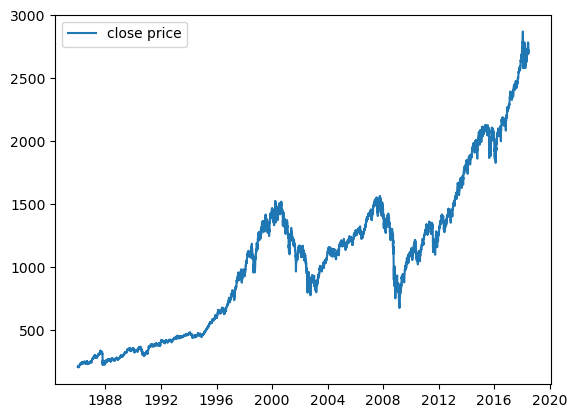

In [3]:
plt.plot(df, label='close price') 
plt.legend()

За последние годы наметилась многообещающая тенденция, которая может представлять хорошую инвестиционную возможность. Возможно, стоит рассмотреть возможность инвестирования в эту тенденцию. Однако важно определить наилучшее время для покупки или продажи. Кроме того, важно выявлять аномалии или внезапные изменения как можно раньше.

### **Предварительная обработка данных**

Шаги:
 1. используем 95% данных для обучения модели
 2. Изменим масштаб данных, используя данные обучения и тестовые данные
 3. разделим данные на подпоследовательности (последовательности с историческими данными за 30 дней:

In [4]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)] 
print(train.shape, test.shape)
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']]) 
test['close'] = scaler.transform(test[['close']])

(7782, 1) (410, 1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
def create_seq(X, y, time_steps=1): 
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values 
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [6]:
TIME_STEPS = 30
# изменить форму на [samples, time_steps, n_features] 
X_train, y_train = create_seq(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_seq(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)
print(X_test.shape)

(7752, 30, 1)
(380, 30, 1)


### **Моделирование**

In [7]:
model = keras.Sequential() 
model.add(keras.layers.LSTM(units=64,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2)) 
model.add(keras.layers.RepeatVector(n=X_train.shape[1])) 
model.add(keras.layers.LSTM(units=64, return_sequences=True)) 
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed( keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam')

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            65        
 ibuted)                                                

* * Слой Repeat Vector дублирует входные данные n раз,
* Установка значения return_sequences=True в слое LSTM возвращает последовательность. 
* * Слой Time Distributed создает вектор с длиной, равной количеству выходных данных предыдущего слоя. 
* Объединив эти слои, мы можем создать автоэнкодер LSTM, готовый к обучению.

Процесс обучения аналогичен процессу обучения в обычной модели LSTM. Наконец, мы добавили распределенный по времени (плотный(X_train.shape[2])) слой в конце сети, чтобы получить выходные данные, где X_train.shape[2] представляет количество объектов во входных данных

### ** Обучение Модели**

In [9]:
history = model.fit( X_train, y_train, epochs=10, batch_size=32, 
                    validation_split=0.1, shuffle=False)

Epoch 1/10
218/218 [==============================] - 10s 12ms/step - loss: 0.1674 - val_loss: 0.1913
Epoch 2/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1037 - val_loss: 0.1569
Epoch 3/10
218/218 [==============================] - 1s 6ms/step - loss: 0.0984 - val_loss: 0.1926
Epoch 4/10
218/218 [==============================] - 1s 6ms/step - loss: 0.0999 - val_loss: 0.2006
Epoch 5/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1065 - val_loss: 0.2770
Epoch 6/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1164 - val_loss: 0.2205
Epoch 7/10
218/218 [==============================] - 1s 6ms/step - loss: 0.0915 - val_loss: 0.3286
Epoch 8/10
218/218 [==============================] - 1s 7ms/step - loss: 0.1275 - val_loss: 0.1865
Epoch 9/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1092 - val_loss: 0.1533
Epoch 10/10
218/218 [==============================] - 1s 6ms/step - loss: 0.1179 - val_loss: 0.14

### **Оценка**

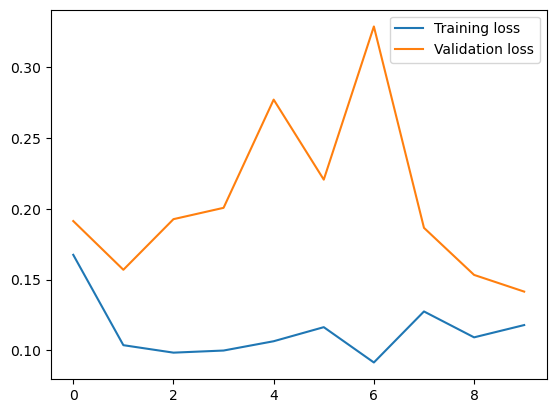

In [10]:
plt.plot(history.history['loss'], label='Training loss') 
plt.plot(history.history['val_loss'], label='Validation loss') 
plt.legend()

#### В конце обучения модели потери при проверке увеличились. Чтобы избежать этого, можно было бы использовать обратные вызовы, такие как ранняя остановка.

In [11]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 3ms/step - loss: 0.6093


0.6093162894248962

#### Выходные данные показывают, что процесс оценки проводился на 12 партиях, и средняя потеря в тестовом наборе составила 0,7052039504051208

#### Значение 0,7052039504051208, выведенное после пакетного вывода, является окончательным значением потерь, возвращаемым функцией evaluate. Это означает, что модель работает хорошо с точки зрения обнаружения аномалий в тестовых данных. Меньшее значение потерь указывает на более высокую производительность.

### **Обнаружение аномалий**

In [12]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

243/243 [==============================] - 1s 3ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:ylabel='Density'>

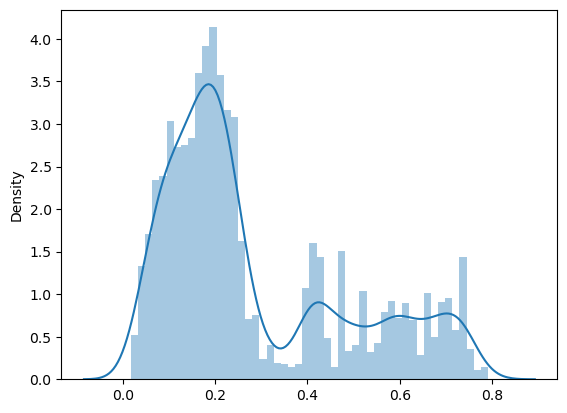

In [13]:
sns.distplot(train_mae_loss, bins=50, kde=True)

### Выберим пороговое значение 0,8, так как потери не намного превышают это значение. Когда ошибка превысит это значение, мы объявим этот пример аномалией

In [14]:
THRESHOLD = 0.8
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

12/12 [==============================] - 0s 3ms/step


In [15]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index) 
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold 
test_score_df['close'] = test[TIME_STEPS:].close

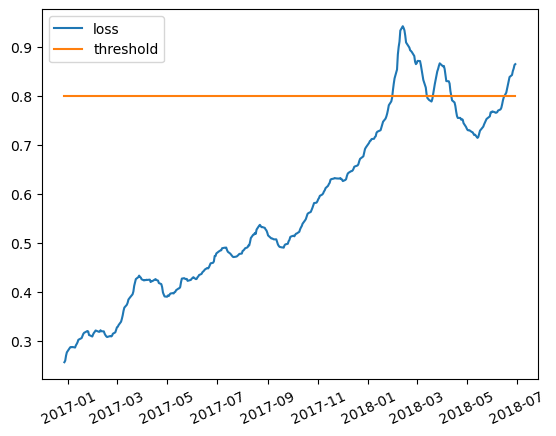

In [16]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss') 
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold') 
plt.xticks(rotation=25)
plt.legend()

#### Похоже, что мы эффективно применяем пороговое значение для отфильтровывания экстремальных значений.

In [17]:
anomalies = test_score_df[test_score_df.anomaly == True] 
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-01-31,0.812048,0.8,True,3.435135
2018-02-01,0.825223,0.8,True,3.431698
2018-02-02,0.836376,0.8,True,3.319282
2018-02-05,0.854394,0.8,True,3.106679
2018-02-06,0.885132,0.8,True,3.193456


#### **Построение графика окончательных результатов**

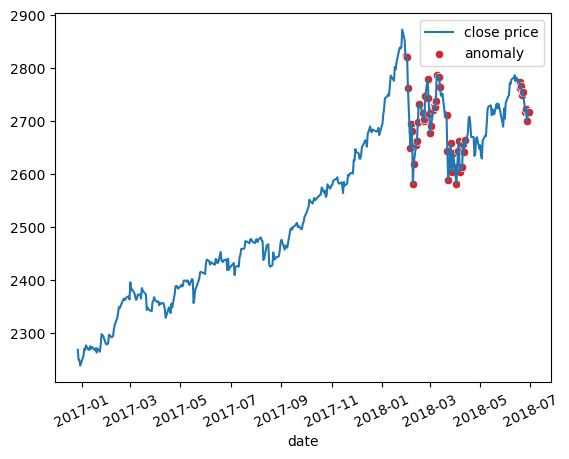

In [18]:
anomalies_close = anomalies[["close"]].values.flatten()
anomalies_close = anomalies_close.reshape(-1, 1) # Reshape to a 2D array
anomalies_close = scaler.inverse_transform(anomalies_close)

plt.plot(test[TIME_STEPS:].index, 
         scaler.inverse_transform(test[TIME_STEPS:][["close"]]), 
         label='close price')

# convert it to a 1D array for the plot
anomalies_close = anomalies_close.flatten()
sns.scatterplot(x=anomalies.index, 
                y=anomalies_close, 
                color=sns.color_palette()[3], 
                label='anomaly'
               )

plt.xticks(rotation=25) 
plt.legend()

#### При ближайшем рассмотрении мы видим, что аномалии, обозначенные красными точками, по-видимому, присутствуют в основном в областях, где происходят внезапные изменения цены закрытия.

## Этот код полезен для обнаружения аномалий во временных рядах, таких как цены акций, с использованием методов глубокого обучения. 